C:\Users\giuli\AppData\Local\Temp\ipykernel_23964\4219794048.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)
C:

Processed 20 episodes.
Error Statistics:
  Max: 0.00021469227098326536
  Min: -0.00013654176775922247
  Mean: 7.704320194585933e-05
  Median: 3.195716379545676e-07
  Std: 8.060405838704394e-05
  25th_percentile: 1.6400464255135684e-08
  75th_percentile: 0.00015826338467413322


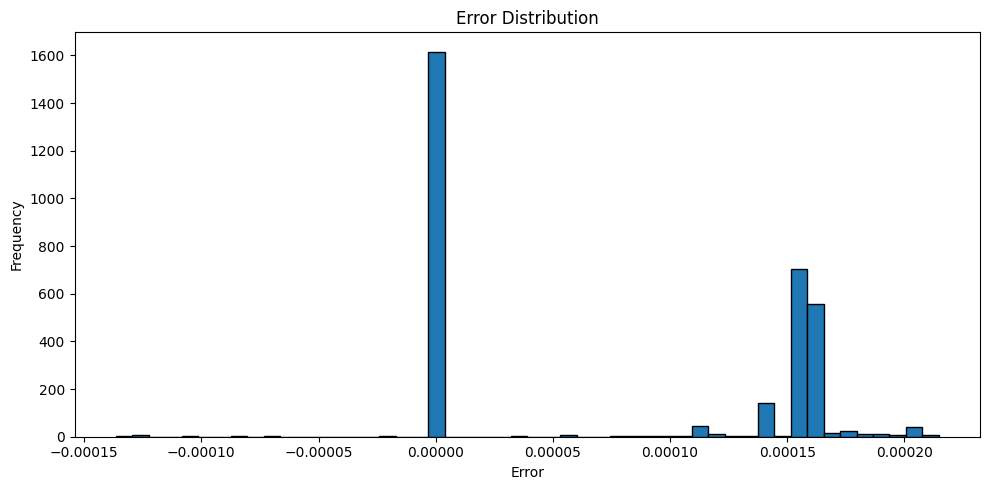

In [3]:
import core_FPGA as core
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Initialize model and set device
hidden_sizes = [core.N_HIDDEN_1, core.N_HIDDEN_2]
device = torch.device('cuda:0')

# Load the saved model
def load_model(experiment_folder):
  model_path = os.path.join(experiment_folder, 'model', 'model.pth')
  
  # Instantiate the model with the same architecture as when it was saved
  model = core.Digital_twin(core.N_INPUT, 1, hidden_sizes, device).to(device)
  
  # Load the state dict
  state_dict = torch.load(model_path, map_location=device)
  
  # Try to load the state dict, ignoring mismatched keys
  model.load_state_dict(state_dict, strict=False)
  
  model.eval()
  return model

# Load saved data
def load_data(experiment_folder, episode):
  data_folder = os.path.join(experiment_folder, 'data')
  obs = np.load(os.path.join(data_folder, f'obs_episode_{episode}.npy'))
  actions = np.load(os.path.join(data_folder, f'actions_episode_{episode}.npy'))
  return obs, actions

# Get the number of saved data files
def get_num_episodes(experiment_folder):
  data_folder = os.path.join(experiment_folder, 'data')
  return len([f for f in os.listdir(data_folder) if f.startswith('obs_episode_') and f.endswith('.npy')])

# Matrix operations
def matrix_multiply_sw(A, B):
  return np.dot(A, B).astype(np.int64)

def matrix_add_sw(A, B):
  return (A + B).astype(np.int64)

def apply_relu_sw(matrix):
  return np.maximum(matrix, 0).astype(np.int64)

# Forward Pass
def forward_pass_sw(X, W1, b1, W2, b2, W3, b3):
  A1 = apply_relu_sw(matrix_add_sw(matrix_multiply_sw(W1, X), b1))
  A2 = apply_relu_sw(matrix_add_sw(matrix_multiply_sw(W2, A1), b2))
  return matrix_add_sw(matrix_multiply_sw(W3, A2), b3).astype(np.int64)

# Function to calculate error statistics
def calculate_error_stats(error_list):
  error_array = np.array(error_list)
  return {
      'max': np.max(error_array),
      'min': np.min(error_array),
      'mean': np.mean(error_array),
      'median': np.median(error_array),
      'std': np.std(error_array),
      '25th_percentile': np.percentile(error_array, 25),
      '75th_percentile': np.percentile(error_array, 75),
  }

# Initialize variables
experiment_folder = './saving_data_scope/'
N_RUNS = get_num_episodes(experiment_folder)
errors = []

# Load the saved model
model = load_model(experiment_folder)

# Load saved data for the first run 
obs, actions = load_data(experiment_folder, 0)

# Use the first observation to get the scale
in_float = torch.tensor(obs[0, :].reshape(1, -1), dtype=torch.float32, device=device)
out_brevitas = model(in_float)

# Extract and convert weights and biases to numpy arrays
W1_sw = model.fc1.quant_weight().int().cpu().numpy().astype(np.int64)
b1_sw = model.fc1.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
W2_sw = model.fc2.quant_weight().int().cpu().numpy().astype(np.int64)
b2_sw = model.fc2.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)
W3_sw = model.fc3.quant_weight().int().cpu().numpy().astype(np.int64)
b3_sw = model.fc3.quant_bias().int().cpu().numpy().astype(np.int64).reshape(-1, 1)

# Perform runs to compare results
for run in range(N_RUNS):
  # Load saved data for each run
  obs, actions = load_data(experiment_folder, run)
  
  # Loop over all observations in the episode
  for i in range(obs.shape[0]):
      # Ensure input tensor has shape (1, 2)
      in_float = torch.tensor(obs[i, :].reshape(1, -1), dtype=torch.float32, device=device)
      
      try:
          out_brevitas = model(in_float)
          out_brevitas_int = out_brevitas.int().cpu().numpy().astype(np.int64)
      except Exception as e:
          print(f"Error occurred in run {run}, observation {i}: {e}")
          print(f"Input tensor: {in_float}")
          continue

      in_float = in_float * 12000.
      X_sw = in_float.view(-1, 1).cpu().numpy().astype(np.int64)
      Y_pred_64 = forward_pass_sw(X_sw, W1_sw, b1_sw, W2_sw, b2_sw, W3_sw, b3_sw)

      # Calculate and append errors for both outputs
      for j in range(2):
          error = (out_brevitas_int[0, j] - Y_pred_64[j, 0]) / Y_pred_64[j, 0]
          errors.append(error)

# Calculate and print error statistics
stats = calculate_error_stats(errors)
print(f"Processed {N_RUNS} episodes.")
print("Error Statistics:")
for stat_name, stat_value in stats.items():
  print(f"  {stat_name.capitalize()}: {stat_value}")

# Plot error distribution
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [4]:
obs, actions = load_data(experiment_folder, 0)

In [12]:
actions[0]

9523.576171875

In [14]:
obs[0][0]

0.26425

In [ ]:
    def process_episode(o, ep_len): 
        ep_ret = 0
        acts, obs, rews = [], [], []
        
        obs.append(o)
        
        for step in range(ep_len):
            global global_t
            global_t += 1

            # Until the start_episode is reached, we randomly sample actions
            # from a uniform distribution for better exploration. Afterwards, 
            # use the learned policy. 
            if global_t > start_episode * ep_len:
                a = get_action(o)
            else:
                a = torch.as_tensor(env.action_space.sample(), dtype=torch.float32, device=device)

            # Step the env
            o2, r, d, _ = env.step(a.view(-1).cpu().numpy())
            ep_ret += r
            
            # Convert o2, r, d to tensors and move them to the appropriate device
            o2 = torch.as_tensor(o2, dtype=torch.float32, device=device).view(1, -1)
            r = torch.as_tensor(r, dtype=torch.float32, device=device)
            d = torch.as_tensor(d, dtype=torch.float32, device=device)

            # Log action
            wandb.log({"actions": a.cpu().numpy()}, step=global_t)
            
            # Populate the lists
            obs.append(o2)
            acts.append(a)
            rews.append(r)

            # Super critical, easy to overlook step: make sure to update 
            # most recent observation!
            o = o2

        # Log epoch return
        wandb.log({"EpRet": ep_ret, "EpLen": ep_len}, step=global_t)
        logger.store(EpRet=ep_ret, EpLen=ep_len)
        # restart
        o = env.reset()
        o = torch.as_tensor(o, dtype=torch.float32, device=device).view(1, -1)        
        return obs, acts, rews